In [2]:

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from sympy import init_printing, lambdify

# magnetic force on iron piece

In [3]:
r = 0.02 #m  1 cm #for 40kHz transducer needds to be at least 1.7 cm radius to be resolved well

def volume(r):
    V = (4/3) * np.pi * r**3
    return V

def iron_sphere_gravity_force(r, g=9.81, rho=7870):  #rho in ρ=7870kg/m3 ,

    V = volume(r)
   
    mass = rho * V
    F = mass * g
    return mass, F

# example call
mass, F_g = iron_sphere_gravity_force(r)

print(round(mass,2),'mass in kg')
print(round(F_g,2),'force in N')


0.26 mass in kg
2.59 force in N


In [14]:
Ms = 217.6   #A m^2/kg 
ratio = 0.2
control_time = 0.006  #s
# general: 1 emg/g = 1 A m^2/kg = J/(T kg)    #https://royalsocietypublishing.org/doi/10.1098/rspa.1971.0044


def dipole_moment_iron(Ms,r,ratio):
    #depending on achieavable field, ratio of saturation is achieved
    #not clear at whcih field this would be because of easy ratio assumption!
    V = volume(r)   #kg/m^3
    m = Ms * V * ratio
    return m   #A/m  #stimmt



m_iron = dipole_moment_iron(Ms,r, ratio)
print(f"Iron sphere dipole moment: {m_iron:.3e} A·m²")   
print(f"Iron sphere dipole moment: {m_iron*1000000:.3e} memu")  #72 memu at 30 mT   checked  1A\cdotpm²=1,000,000memu checked

def necessary_gradient(m, F_g):     #A/m , N   
    #1T = kg/(s^2*A)
    dB_dz = F_g / m   
    return dB_dz   #T/m

dB_dz = necessary_gradient(m_iron, F_g)
print(f"Necessary magnetic field gradient: {dB_dz:.3e} T/m")
print(f"Necessary magnetic field gradient: {dB_dz*1000:.3e} mT/m")   #up to 350 mT/m achieved by Navion 30mT

def move(F, control_time, mass):
    #F in N, time in s, mass in kg
    a = F / mass
    d = 0.5 * a * control_time**2
    return d  #m

displacement = move(F_g, control_time=control_time, mass=mass)  #10 ms
print(f"Displacement in {control_time*1e3} ms: {displacement*1e3:.2f} mm")  #in micrometers


Iron sphere dipole moment: 1.458e-03 A·m²
Iron sphere dipole moment: 1.458e+03 memu
Necessary magnetic field gradient: 1.774e+03 T/m
Necessary magnetic field gradient: 1.774e+06 mT/m
Displacement in 6.0 ms: 0.18 mm



# lets see what magnetic field we can generate with simple coils!
#### usb c cable liefert 1.2 A
- did not use explizit summation over all windings, summing along x becaues approximatin via analytical formula should suffice and make derivative easier

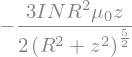

In [5]:


# enable nice display in Jupyter
init_printing(use_latex=True)

# symbols
z, R, l, N, I, mu_0 = sp.symbols('z R l N I mu_0')

# 1️⃣ Single loop approximation
Bz_single = (mu_0 * I * N * R**2) / (2 * (R**2 + z**2)**(sp.Rational(3,2)))
dBz_single = sp.diff(Bz_single, z)
dBz_single_simpl = sp.simplify(dBz_single)

# 2️⃣ Finite-length solenoid
Bz_solenoid = (mu_0 * N * I / 2) * (
    (z + l/2) / (l * sp.sqrt(R**2 + (z + l/2)**2)) -
    (z - l/2) / (l * sp.sqrt(R**2 + (z - l/2)**2))
)
dBz_solenoid = sp.diff(Bz_solenoid, z)
dBz_solenoid_simpl = sp.simplify(dBz_solenoid)

dBz_single_simpl


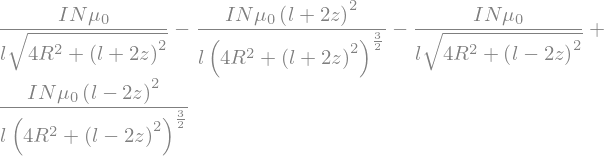

In [6]:
dBz_solenoid_simpl

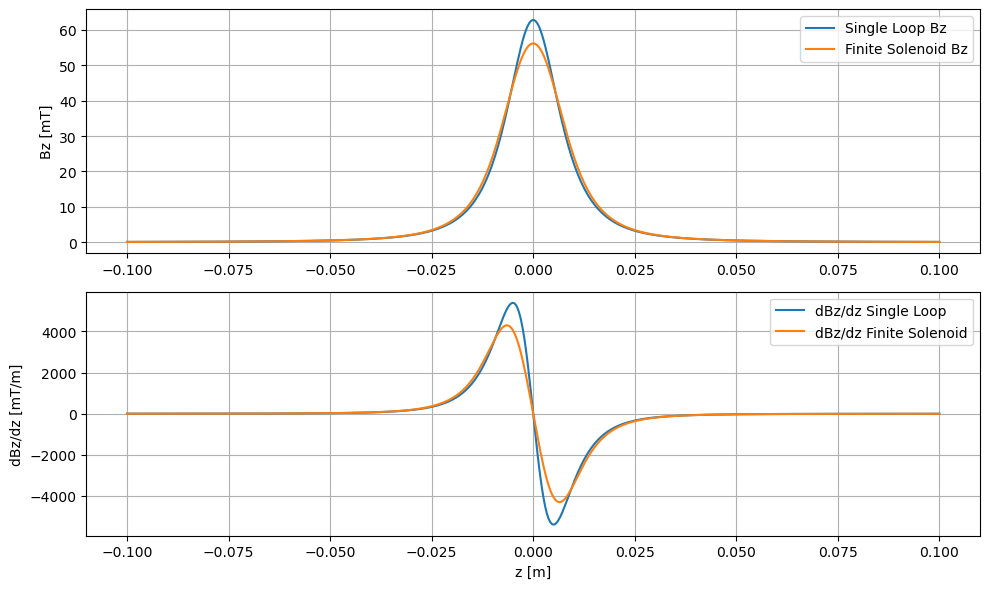

In [7]:
z_max = 0.10


N_num = 1000
R_num = 0.01
L_num = 0.01
I_num = 1.0  #depends on resitance  of circuit! but probably only coil because its paralell!
mu_0_num = 4 * np.pi * 1e-7


Bz_single_num = lambdify(z, Bz_single.subs({R:R_num, N:N_num, I:I_num, mu_0:mu_0_num}), 'numpy')
dBz_single_num = lambdify(z, dBz_single_simpl.subs({R:R_num, N:N_num, I:I_num, mu_0:mu_0_num}), 'numpy')
    
Bz_solenoid_num = lambdify(z, Bz_solenoid.subs({R:R_num, l:L_num, N:N_num, I:I_num, mu_0:mu_0_num}), 'numpy')
dBz_solenoid_num = lambdify(z, dBz_solenoid_simpl.subs({R:R_num, l:L_num, N:N_num, I:I_num, mu_0:mu_0_num}), 'numpy')

z_vals = np.linspace(-z_max, z_max, 500)

# 5️⃣ Evaluate
B_single_vals = Bz_single_num(z_vals)
dB_single_vals = dBz_single_num(z_vals)

B_sol_vals = Bz_solenoid_num(z_vals)
dB_sol_vals = dBz_solenoid_num(z_vals)

# 6️⃣ Plot
plt.figure(figsize=(10,6))

plt.subplot(2,1,1)
plt.plot(z_vals, B_single_vals*1e3, label='Single Loop Bz')
plt.plot(z_vals, B_sol_vals*1e3, label='Finite Solenoid Bz')
plt.ylabel('Bz [mT]')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(z_vals, dB_single_vals*1e3, label="dBz/dz Single Loop")
plt.plot(z_vals, dB_sol_vals*1e3, label="dBz/dz Finite Solenoid")
plt.xlabel('z [m]')
plt.ylabel('dBz/dz [mT/m]')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Calc coil properties

In [8]:
def wire_length(L, R, d_w):  #cgpt checked #neglects last layer! L length of coil, d diameter of coil, d_w diameter of wire
    n_max = int(R/(d_w))
    n = np.arange(1, n_max)
    U = 2*np.pi*np.sum(R-(n*d_w))  #tested
    m = L/d_w
    return U*m

length_wire = wire_length(L=L_num, R=R_num, d_w=0.0002)  #m  0.2 mm wire durchmesser standard!
print(f"Length of wire needed for coil: {length_wire:.3f} m")

Length of wire needed for coil: 76.969 m


In [9]:
def coil_N(L, R, d_w):  #gpt checked
    m = int(L/d_w)
    n_max = int(R/(d_w))
    return n_max * m
coil_N(L=L_num, R=R_num, d_w=0.0002)  #m  0.2 mm wire durchmesser standard!